In [31]:
import numpy as np
import cv2
from numpy.fft import fft2, ifft2, fftshift, ifftshift
import matplotlib.pyplot as plt

In [ ]:
def make_laplacian_filter(num_rows, num_cols, sigma):
    center_i = num_rows // 2
    center_j = num_cols // 2
    def laplacian(i, j):
        coefficient = -1.0 * ((i - center_i)**2 + (j - center_j)**2) / (2 * sigma**2)
        return coefficient
    return np.array([[laplacian(i, j) for j in range(num_cols)] for i in range(num_rows)])

def low_pass(image_matrix, sigma):
    n, m = image_matrix.shape
    return ifft2(ifftshift(make_laplacian_filter(n, m, sigma) * fftshift(fft2(image_matrix))))

def high_pass(image_matrix, sigma):
    return image_matrix - low_pass(image_matrix, sigma)

def create_hybrid_image(image1, image2, sigma1, sigma2, num_levels):
    # Apply high-pass filter to image1
    high_freq = high_pass(image1, sigma1)

    # Apply low-pass filter to image2
    low_freq = low_pass(image2, sigma2)

    # Compute the Laplacian pyramid of the low-pass filtered image
    pyramid = []
    temp = low_freq.copy()
    for i in range(num_levels):
        blurred = cv2.GaussianBlur(temp.astype(np.float32), (5, 5), 0)
        pyramid.append(temp - blurred)
        temp = cv2.resize(blurred, (0, 0), fx=0.5, fy=0.5).astype(np.float32)

    # Reconstruct the hybrid image by combining the Laplacian pyramid of the low-pass filtered image and the high-pass filtered image
    temp = high_freq.copy()
    for i in reversed(range(num_levels)):
        temp = cv2.resize(temp.astype(np.float32), (pyramid[i].shape[1], pyramid[i].shape[0]))
        temp = temp + pyramid[i]

    return np.abs(temp)

In [32]:
# Load the input images
image1 = cv2.imread('einstein.png', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('marilyn.png', cv2.IMREAD_GRAYSCALE)

C:\Users\Mohsen\AppData\Local\Temp\ipykernel_3404\3197393205.py:33: ComplexWarning: Casting complex values to real discards the imaginary part
  blurred = cv2.GaussianBlur(temp.astype(np.float32), (5, 5), 0)
C:\Users\Mohsen\AppData\Local\Temp\ipykernel_3404\3197393205.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  temp = cv2.resize(temp.astype(np.float32), (pyramid[i].shape[1], pyramid[i].shape[0]))


Text(0.5, 1.0, 'Hybrid image')

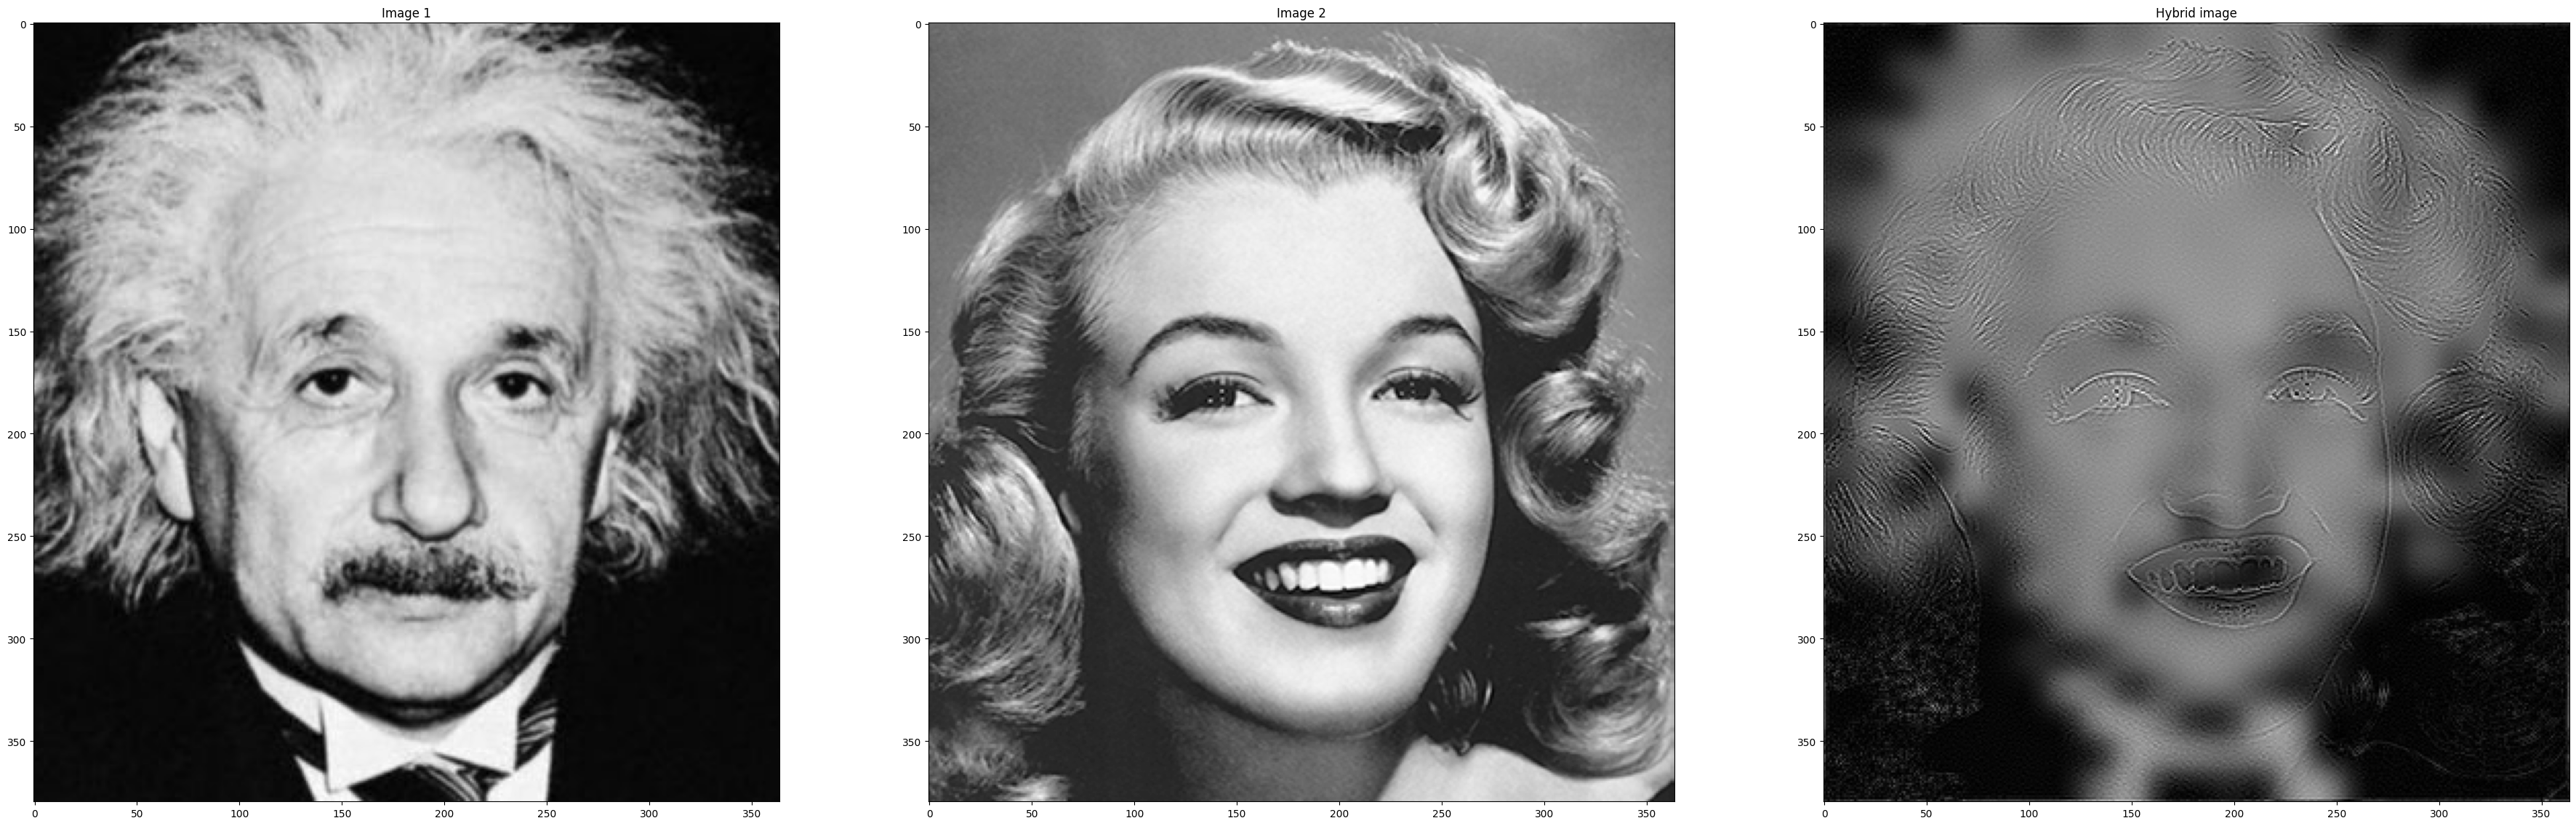

In [43]:
# Create the hybrid image with sigma1=50, sigma2=50, and num_levels=5
hybrid = create_hybrid_image(image1, image2, 50, 50, 5)

fig, axs = plt.subplots(1, 3)
fig.set_figheight(15)
fig.set_figwidth(45)

axs[0].imshow(image1, cmap='gray')
axs[0].set_title('Image 1')
axs[1].imshow(image2, cmap='gray')
axs[1].set_title('Image 2')
axs[2].imshow(hybrid, cmap='gray')
axs[2].set_title('Hybrid image')